# Assginment \#3
ENGG701

Hasan AlJamea - 202012499

# Non-linear equations system solve via Newton method
$$\mathbf{F}(\mathbf{x}) =
\begin{bmatrix}
    f_1(x_1, x_2, \dots, x_n) \\
    f_2(x_1, x_2, \dots, x_n) \\
    \vdots \\
    f_n(x_1, x_2, \dots, x_n)
\end{bmatrix}
= \mathbf{0}$$

Taylor Expansion Approximation up to 2 terms

$$\mathbf{F}(\mathbf{x}^{(k)} + \Delta \mathbf{x}) \approx \mathbf{F}(\mathbf{x}^{(k)}) + J(\mathbf{x}^{(k)}) \Delta \mathbf{x} + ... = 0$$

where J(x) is the Jacobian matrix of F(x)

$$J(\mathbf{x}) =
\begin{bmatrix}
    \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \dots & \frac{\partial f_1}{\partial x_n} \\
    \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \dots & \frac{\partial f_2}{\partial x_n} \\
    \vdots & \vdots & \ddots  & \vdots \\
    \frac{\partial f_n}{\partial x_1} & \frac{\partial f_n}{\partial x_2} & \dots & \frac{\partial f_n}{\partial x_n}
\end{bmatrix}$$

Thus iteration formula is :

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - J(\mathbf{x}^{(k)})^{-1} \mathbf{F}(\mathbf{x}^{(k)})$$

## Python Implementation

```mermaid
classDiagram
    class Numerical {
        + List~StopCondition~ stop_conditions
        + int max_iterations
        + NumericalHistory _history
        + int _iteration
        + float tolerance
        + int patience
        + dict initial_state()*
        + Dict~str, Any~ step()*
        + DataFrame run()
    }

    class NonLinearEquationsNewtonMethod {
        - dict initial_state()
        - Dict~str, Any~ step()
    }

    Numerical <|-- NonLinearEquationsNewtonMethod
```

```python
from dataclasses import dataclass, field
from typing import List

import numpy as np
import sympy

from Core import Numerical
from StopConditions.StopAtOrderOfMagnitudeIncrease import StopAtOrderOfMagnitudeIncrease
from StopConditions.StopIfEqual import StopIfZero
from StopConditions.StopIfNaN import StopIfNaN
from utils.ValidationTools import is_nan


@dataclass
class NonLinearEquationsNewtonMethod(Numerical):
    equations:List[sympy.Expr] = field(default_factory=list)
    jacobian:sympy.Matrix = field(default=None, init=False)
    initial_guess:dict = field(default_factory=dict)
    variables:List[str] = field(default_factory=list, init=False)

    def __post_init__(self):
        if len(self.equations) == 0:
            raise ValueError("Must specify at least one equation")

        variables = set()
        for eq in self.equations:
            variables |= {str(v) for v in eq.free_symbols}
        self.variables: list = sorted(variables)

        self.jacobian = sympy.Matrix(self.equations).jacobian(list(self.variables))

        missing_initial_guess = set(self.variables) - set(self.initial_guess.keys())
        if missing_initial_guess:
            raise ValueError(f"Missing initial guess for {missing_initial_guess}")

        self.add_stop_condition(StopIfZero(tracking='residue', patience=self.patience,
                                           absolute_tolerance=self.absolute_tolerance,
                                           relative_tolerance=self.relative_tolerance))
        self.add_stop_condition(StopAtOrderOfMagnitudeIncrease(
            tracking='residue', patience=self.patience,
        ))
        self.add_stop_condition(StopIfNaN(track_variables=['residue'] + list(self.variables)))

    def get_values(self, iteration: int)->dict:
        return {k:v for k,v in self.history.data[iteration].items() if k in list(map(str, self.variables))}

    @property
    def initial_state(self) -> dict:
        f0 = {f'f_{i}': f.subs(self.initial_guess).evalf() for i, f in enumerate(self.equations)}
        f0_values = list(f0.values())
        residue = sympy.Matrix(f0_values).norm(ord=2)
        return {
            **self.initial_guess,
            **f0,
            'residue': residue
        }

    def _no_solution(self)->dict:
        x_dict = {v: np.nan for v in self.variables}
        return {
            **x_dict,
            **{f'f_{i}': eq.subs(x_dict).evalf() for i, eq in enumerate(self.equations)},
            'residue': np.nan
        }

    def step(self):
        """
        $$ X_{k+1} = X_{k} - J(X_k)^{-1} F(X_k) $$
        """
        # Get current variable values
        xk_sub = self.get_values(-1)
        #
        # if np.any([is_nan(_) for _ in self.history.data[-1].values()]):
        #     return self._no_solution()

        xk_values = [xk_sub[v] for v in self.variables]


        xk = sympy.Matrix(xk_values)
        fk = sympy.Matrix([eq.subs(xk_sub) for eq in self.equations])
        jk = self.jacobian.subs(xk_sub)

        try:
            # Calculate ΔX_k = -J(X_k)^(-1) · F(X_k)
            delta_x = -jk.inv() @ fk

            # Calculate X_{k+1} = X_k + ΔX_k
            xk1 = xk + delta_x
        except sympy.matrices.exceptions.NonInvertibleMatrixError:
            self.logger.warning(f"Jacobian not invertible: {jk}")
            return self._no_solution()

        # Convert result to dictionary
        xk1_dict = {v: xk1[i].evalf()  if hasattr(xk[i], 'evalf') else xk1[i]
                    for i, v in enumerate(self.variables)}
        fk1 = {f'f_{i}': eq.subs(xk1_dict).evalf() for i, eq in enumerate(self.equations)}

        return {
            **xk1_dict,
            **fk1,
            'residue': sympy.Matrix([f for f in fk1.values()]).norm(ord=2).evalf()
        }
```

In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from typing import List, Dict
from IPython.core.display import Math, Markdown
from SolveEquations.NonLinearEquationsNewtonMethod import NonLinearEquationsNewtonMethod

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 6)

## Problem 1



In [2]:
x, y, z = sp.symbols('x y z')
display(Markdown(f'Solve for x, y, z:'))
p1f1 = x**2 + y**2 + 2*z**2 -12.05
p1f2 = 4*x-3*y**2 + 2*z**3 - 45.2
p1f3 = 3*y**3-2*z- 17.6
display(Math(f'{sp.latex(p1f1)} = 0'))
display(Math(f'{sp.latex(p1f2)} = 0'))
display(Math(f'{sp.latex(p1f3)} = 0'))

Solve for x, y, z:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
p1_solver = NonLinearEquationsNewtonMethod(
    equations=[p1f1, p1f2, p1f3],
    initial_guess=dict(x=0, y=0, z=0),
)
df1 = p1_solver.run()

2025-03-11 23:54:29,162 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:run:122 - Starting NonLinearEquationsNewtonMethod
2025-03-11 23:54:29,167 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:initialize:68 - Initial state:{'x': 0, 'y': 0, 'z': 0, 'f_0': -12.0500000000000, 'f_1': -45.2000000000000, 'f_2': -17.6000000000000, 'residue': 49.9800210083989}
2025-03-11 23:54:29,169 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:run:127 - Iteration 1 completed
Stop condition [StopIfZero: Stop when 'residue' equals 0 (abs_tol=1e-06) for 3 iterations] NOT met: Variable residue:49.98 != 0 (abs diff: 49.98 > 1e-06)
Stop condition [StopAtOrderOfMagnitudeIncrease: Stop when 'residue' increases by 10^1 and doesn't return for 3 iterations with adaptive baseline] NOT met: Baseline established: 49.98002100839895 (order: 10^1)
Stop condition [StopIfNaN: Stop if any of ['residue', 'x', 'y', 'z'] is NaN] NOT met: No NaN values found
2025-03-11 23:54:29,171 - NonLinearEquationsNewton

In [4]:
df1

,x,y,z,f_0,f_1,f_2,residue
0,0,0,0,-12.0500000000000,-45.2000000000000,-17.6000000000000,49.9800210083989
1,NaN,NaN,NaN,nan,nan,nan,NaN
2,nan,nan,nan,nan,nan,nan,nan


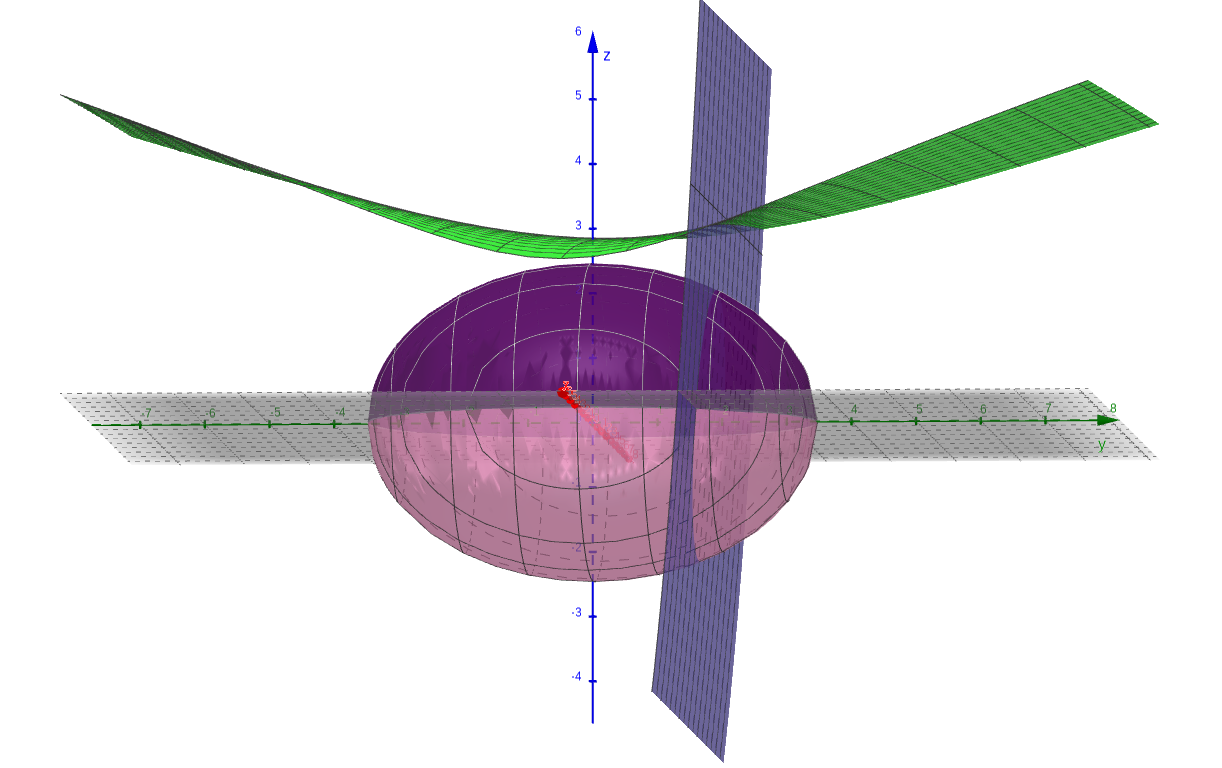

 One of the indecations that there are no real solutions for a system of equations the Jacobian is not invertable martix.  Or the residue which the normal of the vector of $F(x)$ is not convergining. When chosing initaial guess of zeros for this problem an non-inveratble Jacobian matrix was encontered. Thus this problem have no real solutions (see figure above).

## Problem 2

In [5]:
display(Markdown(f'Solve for $x, y, z:$'))
p2f1 = 3*x - sp.cos(y*z)-0.5
p2f2 = x**2 - 81*(y+0.1)**2+sp.sin(z)+1.06
p2f3 = sp.exp(-x*y) - 20*z+(10*np.pi-3)/3
display(Math(f'{sp.latex(p2f1)} = 0'))
display(Math(f'{sp.latex(p2f2)} = 0'))
display(Math(f'{sp.latex(p2f3)} = 0'))

Solve for $x, y, z:$

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
solver_2 = NonLinearEquationsNewtonMethod(
    equations=[p2f1, p2f2, p2f3],
    initial_guess=dict(x=1, y=1, z=1)
)
df2  = solver_2.run()

2025-03-11 23:54:29,270 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:run:122 - Starting NonLinearEquationsNewtonMethod
2025-03-11 23:54:29,279 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:initialize:68 - Initial state:{'x': 1, 'y': 1, 'z': 1, 'f_0': 1.95969769413186, 'f_1': -95.1085290151921, 'f_2': -10.1601450468626, 'residue': 95.6697509867111}
2025-03-11 23:54:29,281 - NonLinearEquationsNewtonMethod - INFO - Numerical.py:run:127 - Iteration 1 completed
Stop condition [StopIfZero: Stop when 'residue' equals 0 (abs_tol=1e-06) for 3 iterations] NOT met: Variable residue:95.6698 != 0 (abs diff: 95.6698 > 1e-06)
Stop condition [StopAtOrderOfMagnitudeIncrease: Stop when 'residue' increases by 10^1 and doesn't return for 3 iterations with adaptive baseline] NOT met: Baseline established: 95.66975098671112 (order: 10^1)
Stop condition [StopIfNaN: Stop if any of ['residue', 'x', 'y', 'z'] is NaN] NOT met: No NaN values found
2025-03-11 23:54:29,386 - NonLinearEquationsNew

In [7]:
df2

,x,y,z,f_0,f_1,f_2,residue
0,1,1,1,1.95969769413186,-95.1085290151921,-10.1601450468626,95.6697509867111
1,0.635864382133408,0.460705391834096,0.508610417991382,0.434920594978965,-23.5143459126248,0.0458294677137658,23.5184123605872
2,0.500766279569584,0.200046901369917,0.519406400234454,0.00769217481907314,-5.48514780493096,-0.0114749838174841,5.48516520140879
3,0.500214458223542,0.0872255338994481,0.521393228850822,0.00167735718499140,-1.03102221391534,0.00141762060967743,1.03102455293859
4,0.499922635459749,0.0532483497453270,0.522278841682951,0.000154593033221406,-0.0935104827543393,0.000129813503772169,0.0935107006470450
5,0.499889279941271,0.0494838348934306,0.522377045285148,1.91229479018507e-6,-0.00114789863070081,1.60622116140985e-6,0.00114790134732152
6,0.499888855194371,0.0494364598682010,0.522378281803356,3.03095770703976e-10,-1.81796034726123e-7,2.54432919177816e-10,1.81796465436758e-7
7,0.499888855127002,0.0494364523629004,0.522378281999251,-1.11022302462516e-16,-5.10702591327572e-15,0,5.10823253489050e-15
8,0.499888855127002,0.0494364523629002,0.522378281999251,1.11022302462516e-16,2.22044604925031e-16,0,2.48253415324727e-16
9,0.499888855127002,0.0494364523629002,0.522378281999251,-1.11022302462516e-16,-4.44089209850063e-16,0,4.57756679852224e-16


In [15]:
display(Markdown('The final solution is:'))
pd.DataFrame(df2.loc[len(df2)-1, ['x','y','z']]).T

The final solution is:

,x,y,z
9,0.499888855127002,0.0494364523629002,0.522378281999251
